# Week 9 Assignment
Pick a stock and download price data. Then resample data to weekly and monthly prices. Determine if there's any seasonality and train a SARIMA model on it to try and predict future prices.

## Data Loading
The stock ticker I am looking at is for Zoom Video Communications Inc. (ZM). The data is downloaded from Yahoo! Finance.

In [ ]:
from google.colab import drive

drive.mount('/data/')
data_dir = '/data/My Drive/GWU/EMSE 6574'
!ls '{data_dir}'

Drive already mounted at /data/; to attempt to forcibly remount, call drive.mount("/data/", force_remount=True).
'EMSE 6574 Final Project - Shared'	'EMSE 6574 Project Proposal.gslides'
'EMSE 6574 Project Meeting Notes.gdoc'	 ZM.csv


In [ ]:
import pandas as pd

zoom_stock = pd.read_csv(f'{data_dir}/ZM.csv')
zoom_stock.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-04-18,65.000000,66.000000,60.320999,62.000000,62.000000,25764700
1,2019-04-22,61.000000,68.900002,59.939999,65.699997,65.699997,9949700
2,2019-04-23,66.870003,74.168999,65.550003,69.000000,69.000000,6786500
3,2019-04-24,71.400002,71.500000,63.160000,63.200001,63.200001,4973500
4,2019-04-25,64.739998,66.849998,62.599998,65.000000,65.000000,3863300


## Data Exploration & Resampling
Let's take a look at the ZM stock over time. Then we'll resample at a weekly and monthly interval to compare.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')

In [ ]:
# Convert `Date` column to datetime
zoom_stock['Date'] = pd.to_datetime(zoom_stock['Date'])
 
# Check column data types to verify
zoom_stock.dtypes

# Set index to `Date` for convenience
zoom_stock = zoom_stock.set_index('Date')

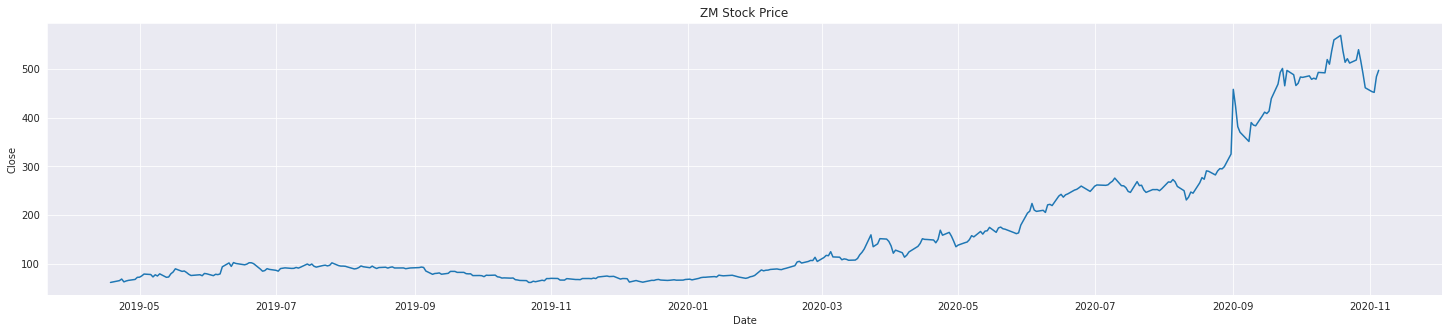

In [ ]:
fig, ax = plt.subplots(figsize = (25, 5))
ax.set_title('ZM Stock Price');
sns.lineplot(data = zoom_stock, x = 'Date', y = 'Close', ax = ax);

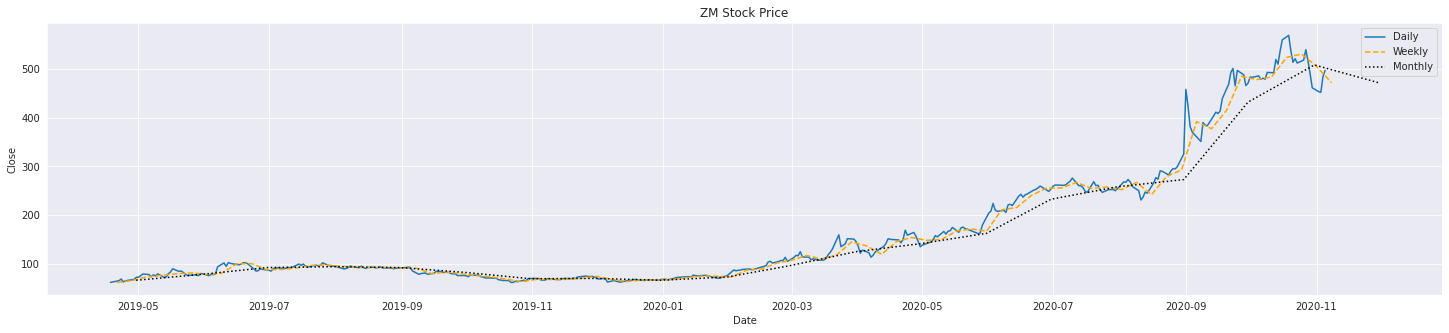

In [ ]:
# Resample to weekly timeframe and use the mean
# as the aggregate for the week
zoom_stock_weekly = zoom_stock.resample('W').mean()

# Resample to monthly timeframe and use the
# mean as the aggregate for the month
zoom_stock_monthly = zoom_stock.resample('M').mean()

# Plot all graphs on plot to compare
fig, ax = plt.subplots(figsize = (25, 5))
ax.set_title('ZM Stock Price');
sns.lineplot(data = zoom_stock, x = 'Date', y = 'Close', ax = ax);
sns.lineplot(data = zoom_stock_weekly, x = 'Date', y = 'Close', ax = ax, color = 'orange', linestyle = '--');
sns.lineplot(data = zoom_stock_monthly, x = 'Date', y = 'Close', ax = ax, color = 'black', linestyle = ':');
ax.legend(labels = ['Daily', 'Weekly', 'Monthly']);

## Seasonality Exploration
Let's see if there's any seasonality to the weekly resampled stock.

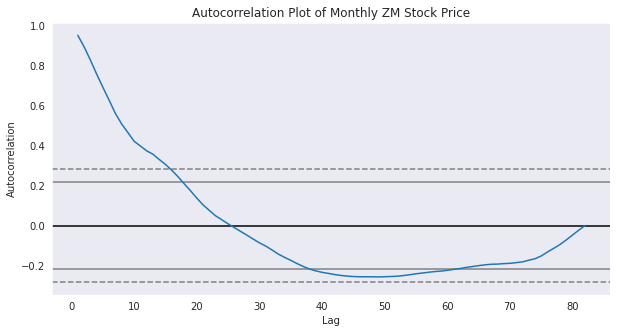

In [ ]:
from pandas.plotting import autocorrelation_plot

fig, ax = plt.subplots(figsize = (10, 5))
ax.set_title('Autocorrelation Plot of Monthly ZM Stock Price');
autocorrelation_plot(zoom_stock_weekly['Close'], ax = ax);

Based on the ACF plot above, there does not seem to be any seasonality; the plot does indicate that it is a **non-stationary** time series so differencing is needed.

## Stationarity Exploration
A time series is stationary if there is no change in mean, variance, and covariance over time. I will test for stationarity using the KPSS (Kwiatkowski–Phillips–Schmidt–Shin) test and ADF (Augmented Dickey-Fuller) test. KPSS tests for trend and level stationarity. We want to accept the null hypotheses for the KPSS tests. ADF tests for a unit root, an indication of non-stationarity. We want to reject the null hypothesis for the ADF test.

In [ ]:
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import adfuller

def test_stationarity(data, verbose=False):
    is_trend_stationary = False
    is_level_stationary = False
    has_no_unit_root = False

    if verbose:
        print('KPSS TESTING'.center(50, '='))

    # KPSS results
    for regression_type in ['c', 'ct']:
        kpss_results = kpss(data, regression = regression_type, lags = 'legacy')

        if verbose:
            reg_type_str = 'trend' if regression_type == 'ct' else 'level'
            print(f'Null Hypothesis: The time series exhibits {reg_type_str} stationarity.')
            print(
                f'Test Statistic:        {kpss_results[0]}\n'
                f'p-value:               {kpss_results[1]}\n'
                f'Lags Used:             {kpss_results[2]}\n'
                f'Critical Value (1%):   {kpss_results[3]["1%"]}\n' 
                f'Critical Value (2.5%): {kpss_results[3]["2.5%"]}\n' 
                f'Critical Value (5%):   {kpss_results[3]["5%"]}\n' 
                f'Critical Value (10%):  {kpss_results[3]["10%"]}' 
            )
            print('~' * 50)
        if kpss_results[1] < 0.05 and kpss_results[0] > kpss_results[3]["5%"]:
            if verbose:
                print(
                    f'The p-value is less than 5% and the test statistic is greater than {kpss_results[3]["5%"]}. Null hypothesis is rejected!'
                )
                print('-' * 50)
        else:
            if verbose:
                print(
                    f'The p-value is greater than 5% and the test statistic is less than {kpss_results[3]["5%"]}. Null hypothesis is not rejected!'
                )
                print('-' * 50)
            if regression_type == 'c':
                is_level_stationary = True
            else:
                is_trend_stationary = True

    # ADF results
    adf_results = adfuller(data)
    if verbose:
        print('')
        print('ADF TESTING'.center(50, '='))
        print('Null Hypothesis: The time series has a unit root.')
        print(
            f'Test Statistic:        {adf_results[0]}\n'
            f'p-value:               {adf_results[1]}\n'
            f'Lags Used:             {adf_results[2]}\n'
            f'Observations Used:     {adf_results[3]}\n'
            f'Critical Value (1%):   {adf_results[4]["1%"]}\n' 
            f'Critical Value (5%):   {adf_results[4]["5%"]}\n' 
            f'Critical Value (10%):  {adf_results[4]["10%"]}' 
        )
        print('~' * 50)
    if adf_results[1] < 0.05 and adf_results[0] < adf_results[4]["5%"]:
        if verbose:
            print(
                f'The p-value is less than 5% and the test statistic is less than {adf_results[4]["5%"]}. Null hypothesis is rejected!'
            )
        has_no_unit_root = True
    else:
        if verbose:
            print(
                f'The p-value is greater than 5% and the test statistic is greater than {adf_results[4]["5%"]}. Null hypothesis is not rejected!'
            )

    is_stationary = is_trend_stationary and is_level_stationary and has_no_unit_root
    if verbose:
        result_str = '' if is_stationary else ' NOT' 
        print(f'\n\nDATA IS{result_str} STATIONARY.')

    return is_stationary

test_stationarity(zoom_stock_weekly['Close'], verbose = True);

===================KPSS TESTING===================
Null Hypothesis: The time series exhibits level stationarity.
Test Statistic:        0.592847309170333
p-value:               0.02328660825724245
Lags Used:             12
Critical Value (1%):   0.739
Critical Value (2.5%): 0.574
Critical Value (5%):   0.463
Critical Value (10%):  0.347
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
The p-value is less than 5% and the test statistic is greater than 0.463. Null hypothesis is rejected!
--------------------------------------------------
Null Hypothesis: The time series exhibits trend stationarity.
Test Statistic:        0.19239365167009997
p-value:               0.018852380623712507
Lags Used:             12
Critical Value (1%):   0.216
Critical Value (2.5%): 0.176
Critical Value (5%):   0.146
Critical Value (10%):  0.119
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
The p-value is less than 5% and the test statistic is greater than 0.146. Null hypothesis is rejected!
-----------

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


The time series failed both KPSS tests and the ADF test at a 5% significance level so we have verified that there is non-stationarity present in the time series. To correct for this, we need to difference the time series and remove trend from it.

## Trend Removal & Differencing
By applying a Box-Cox transform on the time series data, we can detrend the time series which should take care of the KPSS tests. As shown by the output below, we see that that is indeed the case, but the data is still not stationary yet.

In [ ]:
from scipy.stats import boxcox

zoom_stock_weekly['Close_BoxCox'], boxcox_lambda = boxcox(zoom_stock_weekly['Close'])
test_stationarity(zoom_stock_weekly['Close_BoxCox'], verbose = True);

===================KPSS TESTING===================
Null Hypothesis: The time series exhibits level stationarity.
Test Statistic:        0.5979054091609426
p-value:               0.022826780985368854
Lags Used:             12
Critical Value (1%):   0.739
Critical Value (2.5%): 0.574
Critical Value (5%):   0.463
Critical Value (10%):  0.347
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
The p-value is less than 5% and the test statistic is greater than 0.463. Null hypothesis is rejected!
--------------------------------------------------
Null Hypothesis: The time series exhibits trend stationarity.
Test Statistic:        0.14503327074266695
p-value:               0.05179023936543156
Lags Used:             12
Critical Value (1%):   0.216
Critical Value (2.5%): 0.176
Critical Value (5%):   0.146
Critical Value (10%):  0.119
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
The p-value is greater than 5% and the test statistic is less than 0.146. Null hypothesis is not rejected!
------

Now that we have detrended the time series, we should difference the data to pass the ADF test. We need to figure out how many orders of differencing we need by iteratively testing each difference value until we pass the ADF test.

In [ ]:
from statsmodels.tsa.statespace.tools import diff
import warnings

def determine_d(data, max_d=5, verbose=False):
    is_stationary = False
    d = 0
    for diff_num in range(0, max_d + 1):
        if verbose:
            print(f'Testing at differencing order {diff_num}...')
        
        with warnings.catch_warnings():
            warnings.simplefilter('ignore')

            diff_data = diff(data, k_diff = diff_num)
            is_stationary = test_stationarity(diff_data)

            if is_stationary:
                d = diff_num
                break
    else:
        raise ValueError(
            'Could not find a differencing order to satisfy stationarity!'
            f' Try increasing `max_d` (currently {max_d}).'
        )

    if verbose:
        print(f'Best difference order is {d}.')
    
    return d    

d = determine_d(zoom_stock_weekly['Close_BoxCox'], verbose = True)

Testing at differencing order 0...
Testing at differencing order 1...
Best difference order is 1.


## SARIMA Modeling
Now let's try to create a predictive SARIMA model.

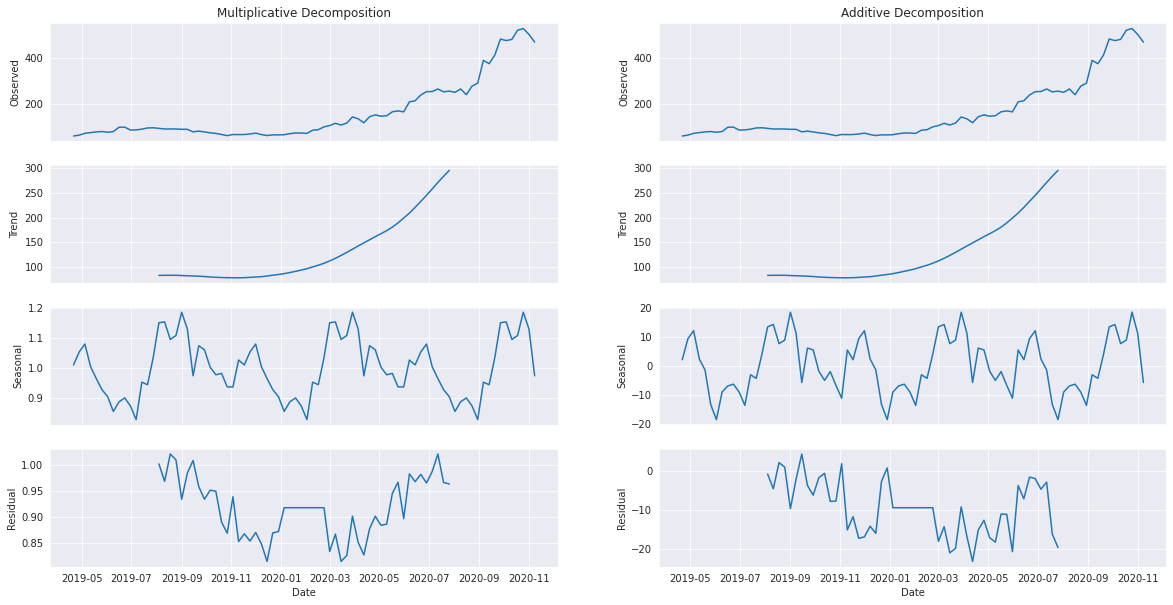

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

fig, axes = plt.subplots(4, 2, sharex = True, figsize = (20, 10))
zoom_stock_mult = seasonal_decompose(zoom_stock_weekly['Close'], model = 'multiplicative', freq = 30)
zoom_stock_add = seasonal_decompose(zoom_stock_weekly['Close'], model = 'additive', freq = 30)

# Multiplicative decomposition
sns.lineplot(data = zoom_stock_mult.observed, x = 'Date', y = zoom_stock_mult.observed, ax = axes[0, 0]);
axes[0, 0].set_ylabel('Observed');
sns.lineplot(data = zoom_stock_mult.trend, x = 'Date', y = zoom_stock_mult.trend, ax = axes[1, 0]);
axes[1, 0].set_ylabel('Trend');
sns.lineplot(data = zoom_stock_mult.seasonal, x = 'Date', y = zoom_stock_mult.seasonal, ax = axes[2, 0]);
axes[2, 0].set_ylabel('Seasonal');
sns.lineplot(data = zoom_stock_mult.resid, x = 'Date', y = zoom_stock_mult.resid, ax = axes[3, 0]);
axes[3, 0].set_ylabel('Residual');
axes[0, 0].set_title('Multiplicative Decomposition');

# Additive decomposition
sns.lineplot(data = zoom_stock_add.observed, x = 'Date', y = zoom_stock_add.observed, ax = axes[0, 1]);
axes[0, 1].set_ylabel('Observed');
sns.lineplot(data = zoom_stock_add.trend, x = 'Date', y = zoom_stock_add.trend, ax = axes[1, 1]);
axes[1, 1].set_ylabel('Trend');
sns.lineplot(data = zoom_stock_add.seasonal, x = 'Date', y = zoom_stock_add.seasonal, ax = axes[2, 1]);
axes[2, 1].set_ylabel('Seasonal');
sns.lineplot(data = zoom_stock_add.resid, x = 'Date', y = zoom_stock_add.resid, ax = axes[3, 1]);
axes[3, 1].set_ylabel('Residual');
axes[0, 1].set_title('Additive Decomposition');

### "I" (Integral - d) Parameter Determination
The "best" integral term was found above (d = 1). This may change depending on further iterations on the model.


### "AR" (Autoregressive - p) Parameter Determination
Because the PACF of the lag-1 differenced time series (above left) shows a sharp cutoff at lag 1, this indicates the series could be slightly underdifferenced. We should add in AR terms equal to where the ACF is significant before it drops off, i.e. p = 7.


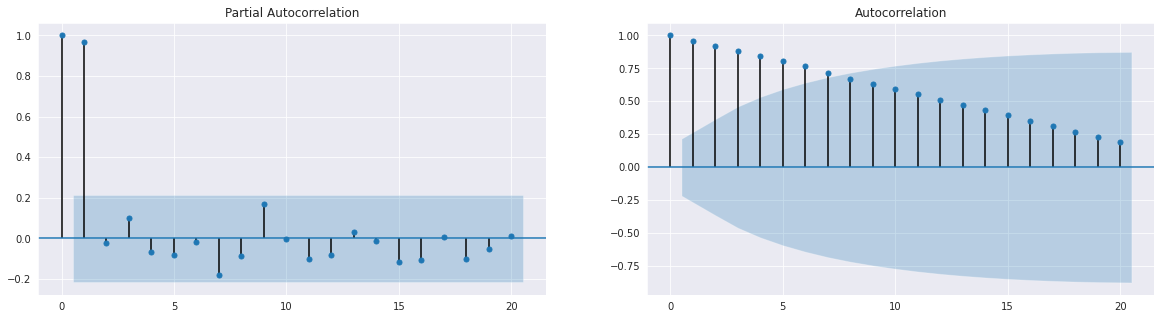

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

fig, axes = plt.subplots(1, 2, figsize = (20, 5))
plot_pacf(zoom_stock_weekly['Close_BoxCox'], ax = axes[0]);
plot_acf(zoom_stock_weekly['Close_BoxCox'], ax = axes[1]);

### "MA" (Moving Average - q) Parameter Determination
The ACF of the lag-1 differenced time series doesn't show a sharp cutoff so this doesn't indicate any overdifferencing. No correction is needed using the moving average, i.e., q = 0.

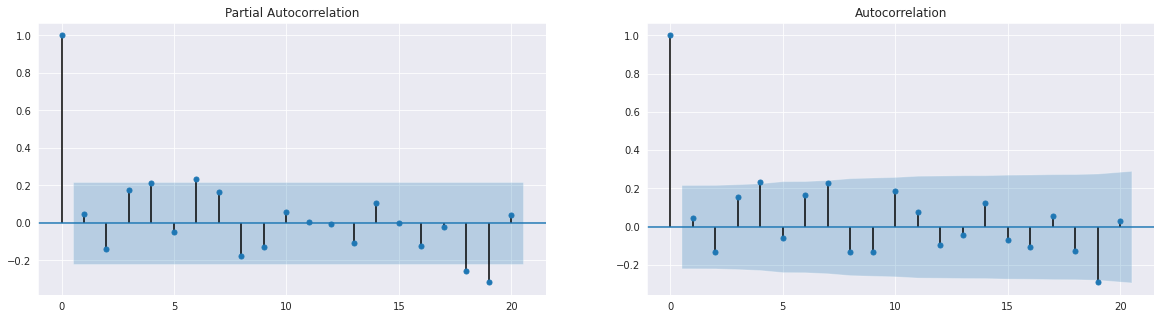

In [ ]:
fig, axes = plt.subplots(1, 2, figsize = (20, 5))
plot_pacf(diff(zoom_stock_weekly['Close_BoxCox'], k_diff = d), ax = axes[0]);
plot_acf(diff(zoom_stock_weekly['Close_BoxCox'], k_diff = d), ax = axes[1]);

### SARIMA Model Fitting

In [ ]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Split data into training and test
train_data = zoom_stock_weekly.iloc[:zoom_stock_weekly.shape[0] - 30].copy()
test_data = zoom_stock_weekly.iloc[zoom_stock_weekly.shape[0] - 30:].copy()

# Box-Cox transform
train_data['Close_BoxCox'] = boxcox(train_data['Close'], lmbda = boxcox_lambda)
test_data['Close_BoxCox'] = boxcox(test_data['Close'], lmbda = boxcox_lambda)

# Fit SARIMA model with p, q, and d values
# from above. No seasonal order values are
# needed because there isn't any seasonality
sarima_model = SARIMAX(
    endog = train_data['Close_BoxCox'],
    freq = 'W',
    order = (
        7,  # p
        1,  # d
        0   # q
    ),
    trend = [1, 0]
).fit()
print(sarima_model.summary())

                           Statespace Model Results                           
Dep. Variable:           Close_BoxCox   No. Observations:                   52
Model:               SARIMAX(7, 1, 0)   Log Likelihood                 269.917
Date:                Sun, 08 Nov 2020   AIC                           -521.835
Time:                        01:59:25   BIC                           -504.449
Sample:                    04-21-2019   HQIC                          -515.191
                         - 04-12-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0002      0.000      0.844      0.399      -0.000       0.001
ar.L1          0.0240      0.183      0.131      0.896      -0.335       0.383
ar.L2         -0.2147      0.120     -1.793      0.0

### SARIMA Test Results

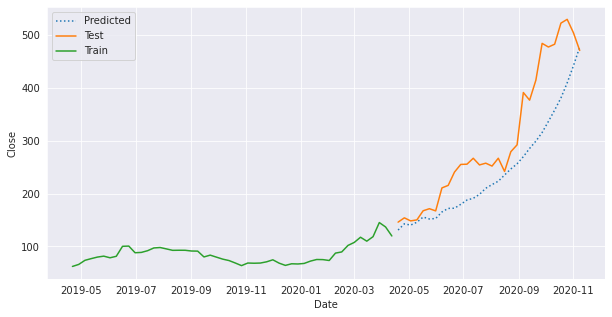

In [ ]:
from scipy.special import inv_boxcox

# Get predictions
start_idx = len(train_data)
end_idx = len(train_data) + len(test_data) - 1
predictions = sarima_model.predict(start_idx, end_idx, typ = 'levels')

# Apply an inverse Box-Cox transform to get back original scale
predictions_inv = inv_boxcox(predictions, boxcox_lambda)

# Plot training, testing, and predictions
fig, ax = plt.subplots(figsize = (10, 5))
sns.lineplot(x = predictions.index, y = predictions_inv, ax = ax, linestyle = ':');
sns.lineplot(x = test_data.index, y = test_data['Close'], ax = ax);
sns.lineplot(x = train_data.index, y = train_data['Close'], ax = ax);
ax.legend(['Predicted', 'Test', 'Train']);

In [ ]:
from sklearn.metrics import mean_squared_error 

rmse = mean_squared_error(test_data['Close'], predictions_inv, squared = False)
print(f'RMSE: {rmse}')

RMSE: 76.53377336312063
